In [ ]:
from PIL import Image
import os
import torch
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_dir = "/content/drive/MyDrive/Subset_128x128"
labels_csv = "/content/drive/MyDrive/labels.csv"

### Using 40 dimensinal Class Embedding Layer using nn.Embedding

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, image_folder, labels_csv, transform=None):
        """
        Args:
            image_folder (str): Path to the main image folder.
            labels_csv (str): Path to the labels CSV file with `filename` and `label` columns.
            transform (callable, optional): Optional transform to be applied on the images.
        """
        self.labels_df = pd.read_csv(labels_csv)  # Load the CSV
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
       
        row = self.labels_df.iloc[idx]
        filename = row["filename"]  
        label = row["label"]        

        # Build the full image path
        synset_id = filename.split('_')[0] 
        image_path = os.path.join(self.image_folder, synset_id, filename)

        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return {"image": image, "label": label}


In [ ]:

image_transforms = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),        
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  
])

In [ ]:
from torch.utils.data import DataLoader


image_dataset = ImageDataset(
    image_folder=image_dir,
    labels_csv=labels_csv,
    transform=image_transforms
)


data_loader = DataLoader(image_dataset, batch_size=16, shuffle=True)


for batch in data_loader:
    print("Image batch shape:", batch["image"].shape)  # Shape: (batch_size, 3, 128, 128)
    print("Label batch shape:", batch["label"].shape)  # Shape: (batch_size,)
    break


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/labels.csv'

In [ ]:
import torch.nn as nn

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, class_dim=40):
        super(Generator, self).__init__()
        self.fc = nn.Linear(noise_dim + class_dim, 4 * 4 * 1024) 
        self.resblock1 = ResBlockUp(1024, 512)
        self.resblock2 = ResBlockUp(512, 256)
        self.resblock3 = ResBlockUp(256, 128)
        self.resblock4 = ResBlockUp(128, 64)
        self.conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.tanh = nn.Tanh() 

    def forward(self, noise, class_embedding):
        x = torch.cat([noise, class_embedding], dim=1)  
        x = self.fc(x).view(-1, 1024, 4, 4) 
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.conv(x)
        return self.tanh(x)

class Discriminator(nn.Module):
    def __init__(self, class_dim=40):
        super(Discriminator, self).__init__()
        self.resblock1 = ResBlockDown(3, 64)
        self.resblock2 = ResBlockDown(64, 128)
        self.resblock3 = ResBlockDown(128, 256)
        self.resblock4 = ResBlockDown(256, 512)
        self.resblock5 = ResBlockDown(512, 1024)
        self.resblock_final = ResBlockDown(1024, 1024)
        self.global_sum_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, 1)

        # Conditional embedding
        self.embed = nn.Linear(class_dim, 1024)

    def forward(self, img, class_embedding):
        x = self.resblock1(img)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock_final(x)
        x = self.global_sum_pooling(x).view(x.size(0), -1)  

        
        condition_embed = self.embed(class_embedding)
        x = x + condition_embed

        return self.fc(x)

In [ ]:
class ResBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlockUp, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),  
            nn.Conv2d(in_channels, out_channels, kernel_size=1) 
        )

    def forward(self, x):
        shortcut = self.upsample(x)  # Shortcut path
        main_path = self.block(F.interpolate(x, scale_factor=2, mode='nearest'))  
        return shortcut + main_path  # Combine paths
class ResBlockDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlockDown, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2) 

    def forward(self, x):
        shortcut = self.downsample(x)  
        main_path = self.block(x)  
        return shortcut + main_path  

In [ ]:
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class_embedding_layer = nn.Embedding(num_embeddings=40, embedding_dim=40).to(device)

In [ ]:
def train_gan(generator, discriminator, data_loader, class_embedding_layer, num_epochs=20, noise_dim=100, lr=0.0002):
   
    optimizer_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

   
    gan_loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(data_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

           
            optimizer_disc.zero_grad()
            batch_size = images.size(0)

           
            noise = torch.randn(batch_size, noise_dim).to(device)
            class_embeddings = class_embedding_layer(labels).detach() 
            fake_images = generator(noise, class_embeddings)

           
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            
            real_loss = gan_loss_fn(discriminator(images, class_embeddings), real_labels)
            fake_loss = gan_loss_fn(discriminator(fake_images.detach(), class_embeddings), fake_labels) 
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            optimizer_disc.step()

           
            optimizer_gen.zero_grad()

            
            noise = torch.randn(batch_size, noise_dim).to(device)
            class_embeddings = class_embedding_layer(labels)  
            fake_images = generator(noise, class_embeddings)

            
            gen_loss = gan_loss_fn(discriminator(fake_images, class_embeddings), real_labels)
            gen_loss.backward()
            optimizer_gen.step()

      
        print(f"Epoch [{epoch + 1}/{num_epochs}] | Gen Loss: {gen_loss.item():.4f} | Disc Loss: {disc_loss.item():.4f}")


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), 
])


image_dataset = ImageDataset(image_folder=image_dir, labels_csv=labels_csv, transform=image_transforms)
data_loader = DataLoader(image_dataset, batch_size=16, shuffle=True)


noise_dim = 100
class_dim = 40 
lr = 0.0002
num_epochs = 20


generator = Generator(noise_dim=noise_dim, class_dim=class_dim).to(device)
discriminator = Discriminator(class_dim=class_dim).to(device)


class_embedding_layer = nn.Embedding(num_embeddings=40, embedding_dim=40).to(device)


train_gan(generator, discriminator, data_loader, class_embedding_layer, num_epochs=num_epochs, noise_dim=noise_dim, lr=lr)

Epoch 1/20


Training Epoch 1/20: 100%|██████████| 125/125 [11:11<00:00,  5.37s/it]


Epoch [1/20] | Gen Loss: 8.7357 | Disc Loss: 0.0008
Epoch 2/20


Training Epoch 2/20: 100%|██████████| 125/125 [00:25<00:00,  4.82it/s]


Epoch [2/20] | Gen Loss: 12.7393 | Disc Loss: 0.0001
Epoch 3/20


Training Epoch 3/20: 100%|██████████| 125/125 [00:26<00:00,  4.79it/s]


Epoch [3/20] | Gen Loss: 13.0433 | Disc Loss: 0.0000
Epoch 4/20


Training Epoch 4/20: 100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Epoch [4/20] | Gen Loss: 15.0665 | Disc Loss: 0.0000
Epoch 5/20


Training Epoch 5/20: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [5/20] | Gen Loss: 10.5754 | Disc Loss: 0.0001
Epoch 6/20


Training Epoch 6/20: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [6/20] | Gen Loss: 10.6108 | Disc Loss: 0.0000
Epoch 7/20


Training Epoch 7/20: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [7/20] | Gen Loss: 13.2657 | Disc Loss: 0.0000
Epoch 8/20


Training Epoch 8/20: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [8/20] | Gen Loss: 15.7211 | Disc Loss: 0.0000
Epoch 9/20


Training Epoch 9/20: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [9/20] | Gen Loss: 12.0073 | Disc Loss: 0.0000
Epoch 10/20


Training Epoch 10/20: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [10/20] | Gen Loss: 14.6445 | Disc Loss: 0.0000
Epoch 11/20


Training Epoch 11/20: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [11/20] | Gen Loss: 14.8837 | Disc Loss: 0.0000
Epoch 12/20


Training Epoch 12/20: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [12/20] | Gen Loss: 16.5090 | Disc Loss: 0.0000
Epoch 13/20


Training Epoch 13/20: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch [13/20] | Gen Loss: 11.8534 | Disc Loss: 0.0000
Epoch 14/20


Training Epoch 14/20: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch [14/20] | Gen Loss: 15.5641 | Disc Loss: 0.0000
Epoch 15/20


Training Epoch 15/20: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [15/20] | Gen Loss: 12.9573 | Disc Loss: 0.0000
Epoch 16/20


Training Epoch 16/20: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [16/20] | Gen Loss: 13.2635 | Disc Loss: 0.0000
Epoch 17/20


Training Epoch 17/20: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [17/20] | Gen Loss: 12.6693 | Disc Loss: 0.0000
Epoch 18/20


Training Epoch 18/20: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [18/20] | Gen Loss: 15.5099 | Disc Loss: 0.0000
Epoch 19/20


Training Epoch 19/20: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [19/20] | Gen Loss: 15.5695 | Disc Loss: 0.0000
Epoch 20/20


Training Epoch 20/20: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [20/20] | Gen Loss: 13.0028 | Disc Loss: 0.0000


In [ ]:

def train_gan(generator, discriminator, data_loader, class_embedding_layer, num_epochs=20, noise_dim=100, lr=0.0002):
   
    optimizer_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=lr * 0.5, betas=(0.5, 0.999)) 

 
    gan_loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(data_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            
            optimizer_disc.zero_grad()
            batch_size = images.size(0)

            
            noise = torch.randn(batch_size, noise_dim).to(device)
            class_embeddings = class_embedding_layer(labels).detach()
            fake_images = generator(noise, class_embeddings)

            
            real_images_noisy = images + 0.05 * torch.randn_like(images).to(device)
            fake_images_noisy = fake_images.detach() + 0.05 * torch.randn_like(fake_images).to(device)

           
            real_labels = torch.full((batch_size, 1), 0.9, device=device)
            fake_labels = torch.full((batch_size, 1), 0.1, device=device)

           
            real_loss = gan_loss_fn(discriminator(real_images_noisy, class_embeddings), real_labels)
            fake_loss = gan_loss_fn(discriminator(fake_images_noisy, class_embeddings), fake_labels)
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            optimizer_disc.step()

            
            optimizer_gen.zero_grad()

            
            noise = torch.randn(batch_size, noise_dim).to(device)
            class_embeddings = class_embedding_layer(labels)
            fake_images = generator(noise, class_embeddings)

           
            gen_loss = gan_loss_fn(discriminator(fake_images, class_embeddings), real_labels)
            gen_loss.backward()
            optimizer_gen.step()

        
        print(f"Epoch [{epoch + 1}/{num_epochs}] | Gen Loss: {gen_loss.item():.4f} | Disc Loss: {disc_loss.item():.4f}")

In [ ]:
train_gan(generator, discriminator, data_loader, class_embedding_layer, num_epochs=100, noise_dim=noise_dim, lr=lr)

Epoch 1/100


Training Epoch 1/100: 100%|██████████| 125/125 [00:29<00:00,  4.25it/s]


Epoch [1/100] | Gen Loss: 2.6183 | Disc Loss: 0.7053
Epoch 2/100


Training Epoch 2/100: 100%|██████████| 125/125 [00:26<00:00,  4.64it/s]


Epoch [2/100] | Gen Loss: 1.3555 | Disc Loss: 0.6533
Epoch 3/100


Training Epoch 3/100: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch [3/100] | Gen Loss: 1.2990 | Disc Loss: 0.6526
Epoch 4/100


Training Epoch 4/100: 100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Epoch [4/100] | Gen Loss: 1.3306 | Disc Loss: 0.6573
Epoch 5/100


Training Epoch 5/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [5/100] | Gen Loss: 1.4664 | Disc Loss: 0.6509
Epoch 6/100


Training Epoch 6/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [6/100] | Gen Loss: 1.4197 | Disc Loss: 0.6506
Epoch 7/100


Training Epoch 7/100: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [7/100] | Gen Loss: 1.5017 | Disc Loss: 0.6538
Epoch 8/100


Training Epoch 8/100: 100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Epoch [8/100] | Gen Loss: 1.4377 | Disc Loss: 0.6516
Epoch 9/100


Training Epoch 9/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [9/100] | Gen Loss: 1.4889 | Disc Loss: 0.6515
Epoch 10/100


Training Epoch 10/100: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [10/100] | Gen Loss: 1.5996 | Disc Loss: 0.6524
Epoch 11/100


Training Epoch 11/100: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [11/100] | Gen Loss: 1.7390 | Disc Loss: 0.6511
Epoch 12/100


Training Epoch 12/100: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [12/100] | Gen Loss: 1.7061 | Disc Loss: 0.6510
Epoch 13/100


Training Epoch 13/100: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [13/100] | Gen Loss: 1.6137 | Disc Loss: 0.6518
Epoch 14/100


Training Epoch 14/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [14/100] | Gen Loss: 1.8054 | Disc Loss: 0.6509
Epoch 15/100


Training Epoch 15/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [15/100] | Gen Loss: 1.7214 | Disc Loss: 0.6507
Epoch 16/100


Training Epoch 16/100: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch [16/100] | Gen Loss: 1.7758 | Disc Loss: 0.6508
Epoch 17/100


Training Epoch 17/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [17/100] | Gen Loss: 1.7699 | Disc Loss: 0.6504
Epoch 18/100


Training Epoch 18/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [18/100] | Gen Loss: 1.7707 | Disc Loss: 0.6507
Epoch 19/100


Training Epoch 19/100: 100%|██████████| 125/125 [00:26<00:00,  4.65it/s]


Epoch [19/100] | Gen Loss: 1.5890 | Disc Loss: 0.6502
Epoch 20/100


Training Epoch 20/100: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch [20/100] | Gen Loss: 2.0868 | Disc Loss: 0.6561
Epoch 21/100


Training Epoch 21/100: 100%|██████████| 125/125 [00:27<00:00,  4.48it/s]


Epoch [21/100] | Gen Loss: 1.7256 | Disc Loss: 0.6502
Epoch 22/100


Training Epoch 22/100: 100%|██████████| 125/125 [00:26<00:00,  4.64it/s]


Epoch [22/100] | Gen Loss: 1.8084 | Disc Loss: 0.6504
Epoch 23/100


Training Epoch 23/100: 100%|██████████| 125/125 [00:26<00:00,  4.64it/s]


Epoch [23/100] | Gen Loss: 1.7699 | Disc Loss: 0.6505
Epoch 24/100


Training Epoch 24/100: 100%|██████████| 125/125 [00:28<00:00,  4.40it/s]


Epoch [24/100] | Gen Loss: 1.7116 | Disc Loss: 0.6539
Epoch 25/100


Training Epoch 25/100: 100%|██████████| 125/125 [00:27<00:00,  4.63it/s]


Epoch [25/100] | Gen Loss: 1.7967 | Disc Loss: 0.6503
Epoch 26/100


Training Epoch 26/100: 100%|██████████| 125/125 [00:26<00:00,  4.65it/s]


Epoch [26/100] | Gen Loss: 1.7498 | Disc Loss: 0.6503
Epoch 27/100


Training Epoch 27/100: 100%|██████████| 125/125 [00:28<00:00,  4.44it/s]


Epoch [27/100] | Gen Loss: 1.7203 | Disc Loss: 0.6502
Epoch 28/100


Training Epoch 28/100: 100%|██████████| 125/125 [00:27<00:00,  4.53it/s]


Epoch [28/100] | Gen Loss: 1.7116 | Disc Loss: 0.6503
Epoch 29/100


Training Epoch 29/100: 100%|██████████| 125/125 [00:26<00:00,  4.66it/s]


Epoch [29/100] | Gen Loss: 1.9936 | Disc Loss: 0.6504
Epoch 30/100


Training Epoch 30/100: 100%|██████████| 125/125 [00:26<00:00,  4.65it/s]


Epoch [30/100] | Gen Loss: 1.6673 | Disc Loss: 0.6502
Epoch 31/100


Training Epoch 31/100: 100%|██████████| 125/125 [00:27<00:00,  4.55it/s]


Epoch [31/100] | Gen Loss: 1.7452 | Disc Loss: 0.6502
Epoch 32/100


Training Epoch 32/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [32/100] | Gen Loss: 1.8536 | Disc Loss: 0.6547
Epoch 33/100


Training Epoch 33/100: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch [33/100] | Gen Loss: 1.7274 | Disc Loss: 0.6503
Epoch 34/100


Training Epoch 34/100: 100%|██████████| 125/125 [00:26<00:00,  4.66it/s]


Epoch [34/100] | Gen Loss: 1.8248 | Disc Loss: 0.6517
Epoch 35/100


Training Epoch 35/100: 100%|██████████| 125/125 [00:26<00:00,  4.65it/s]


Epoch [35/100] | Gen Loss: 1.7577 | Disc Loss: 0.6502
Epoch 36/100


Training Epoch 36/100: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch [36/100] | Gen Loss: 1.9975 | Disc Loss: 0.6504
Epoch 37/100


Training Epoch 37/100: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch [37/100] | Gen Loss: 1.7863 | Disc Loss: 0.6502
Epoch 38/100


Training Epoch 38/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [38/100] | Gen Loss: 1.7540 | Disc Loss: 0.6505
Epoch 39/100


Training Epoch 39/100: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch [39/100] | Gen Loss: 1.7511 | Disc Loss: 0.6513
Epoch 40/100


Training Epoch 40/100: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch [40/100] | Gen Loss: 2.0917 | Disc Loss: 0.6506
Epoch 41/100


Training Epoch 41/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [41/100] | Gen Loss: 1.8281 | Disc Loss: 0.6503
Epoch 42/100


Training Epoch 42/100: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch [42/100] | Gen Loss: 2.2573 | Disc Loss: 0.9171
Epoch 43/100


Training Epoch 43/100: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch [43/100] | Gen Loss: 1.9959 | Disc Loss: 0.6567
Epoch 44/100


Training Epoch 44/100: 100%|██████████| 125/125 [00:26<00:00,  4.66it/s]


Epoch [44/100] | Gen Loss: 1.9048 | Disc Loss: 0.6528
Epoch 45/100


Training Epoch 45/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [45/100] | Gen Loss: 2.1856 | Disc Loss: 0.6525
Epoch 46/100


Training Epoch 46/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [46/100] | Gen Loss: 2.0350 | Disc Loss: 0.6520
Epoch 47/100


Training Epoch 47/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [47/100] | Gen Loss: 2.1514 | Disc Loss: 0.6576
Epoch 48/100


Training Epoch 48/100: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch [48/100] | Gen Loss: 1.7985 | Disc Loss: 0.6546
Epoch 49/100


Training Epoch 49/100: 100%|██████████| 125/125 [00:28<00:00,  4.42it/s]


Epoch [49/100] | Gen Loss: 2.0517 | Disc Loss: 0.6506
Epoch 50/100


Training Epoch 50/100: 100%|██████████| 125/125 [00:27<00:00,  4.47it/s]


Epoch [50/100] | Gen Loss: 2.0122 | Disc Loss: 0.6508
Epoch 51/100


Training Epoch 51/100: 100%|██████████| 125/125 [00:26<00:00,  4.64it/s]


Epoch [51/100] | Gen Loss: 1.9967 | Disc Loss: 0.6505
Epoch 52/100


Training Epoch 52/100: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch [52/100] | Gen Loss: 2.0547 | Disc Loss: 0.6540
Epoch 53/100


Training Epoch 53/100: 100%|██████████| 125/125 [00:27<00:00,  4.58it/s]


Epoch [53/100] | Gen Loss: 1.9898 | Disc Loss: 0.6507
Epoch 54/100


Training Epoch 54/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [54/100] | Gen Loss: 2.0121 | Disc Loss: 0.6508
Epoch 55/100


Training Epoch 55/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [55/100] | Gen Loss: 2.0181 | Disc Loss: 0.6503
Epoch 56/100


Training Epoch 56/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [56/100] | Gen Loss: 2.0590 | Disc Loss: 0.6509
Epoch 57/100


Training Epoch 57/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [57/100] | Gen Loss: 2.0289 | Disc Loss: 0.6510
Epoch 58/100


Training Epoch 58/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [58/100] | Gen Loss: 2.0109 | Disc Loss: 0.6504
Epoch 59/100


Training Epoch 59/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [59/100] | Gen Loss: 1.9793 | Disc Loss: 0.6503
Epoch 60/100


Training Epoch 60/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [60/100] | Gen Loss: 1.9747 | Disc Loss: 0.6503
Epoch 61/100


Training Epoch 61/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [61/100] | Gen Loss: 2.0906 | Disc Loss: 0.6512
Epoch 62/100


Training Epoch 62/100: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch [62/100] | Gen Loss: 2.0075 | Disc Loss: 0.6505
Epoch 63/100


Training Epoch 63/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [63/100] | Gen Loss: 2.0578 | Disc Loss: 0.6502
Epoch 64/100


Training Epoch 64/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [64/100] | Gen Loss: 2.0604 | Disc Loss: 0.6502
Epoch 65/100


Training Epoch 65/100: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch [65/100] | Gen Loss: 2.0829 | Disc Loss: 0.6507
Epoch 66/100


Training Epoch 66/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [66/100] | Gen Loss: 2.0339 | Disc Loss: 0.6505
Epoch 67/100


Training Epoch 67/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [67/100] | Gen Loss: 2.0507 | Disc Loss: 0.6513
Epoch 68/100


Training Epoch 68/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [68/100] | Gen Loss: 2.0332 | Disc Loss: 0.6505
Epoch 69/100


Training Epoch 69/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [69/100] | Gen Loss: 2.0733 | Disc Loss: 0.6511
Epoch 70/100


Training Epoch 70/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [70/100] | Gen Loss: 2.1204 | Disc Loss: 0.6509
Epoch 71/100


Training Epoch 71/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [71/100] | Gen Loss: 2.0610 | Disc Loss: 0.6506
Epoch 72/100


Training Epoch 72/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [72/100] | Gen Loss: 2.0661 | Disc Loss: 0.6504
Epoch 73/100


Training Epoch 73/100: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch [73/100] | Gen Loss: 2.0496 | Disc Loss: 0.6503
Epoch 74/100


Training Epoch 74/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [74/100] | Gen Loss: 2.0168 | Disc Loss: 0.6506
Epoch 75/100


Training Epoch 75/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [75/100] | Gen Loss: 2.0262 | Disc Loss: 0.6503
Epoch 76/100


Training Epoch 76/100: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch [76/100] | Gen Loss: 2.0806 | Disc Loss: 0.6504
Epoch 77/100


Training Epoch 77/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [77/100] | Gen Loss: 2.0626 | Disc Loss: 0.6502
Epoch 78/100


Training Epoch 78/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [78/100] | Gen Loss: 2.0378 | Disc Loss: 0.6502
Epoch 79/100


Training Epoch 79/100: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [79/100] | Gen Loss: 2.0378 | Disc Loss: 0.6502
Epoch 80/100


Training Epoch 80/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [80/100] | Gen Loss: 2.0351 | Disc Loss: 0.6503
Epoch 81/100


Training Epoch 81/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [81/100] | Gen Loss: 2.0818 | Disc Loss: 0.6502
Epoch 82/100


Training Epoch 82/100: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch [82/100] | Gen Loss: 2.0168 | Disc Loss: 0.6502
Epoch 83/100


Training Epoch 83/100: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


Epoch [83/100] | Gen Loss: 2.0597 | Disc Loss: 0.6505
Epoch 84/100


Training Epoch 84/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [84/100] | Gen Loss: 2.0610 | Disc Loss: 0.6503
Epoch 85/100


Training Epoch 85/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [85/100] | Gen Loss: 2.0505 | Disc Loss: 0.6504
Epoch 86/100


Training Epoch 86/100: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch [86/100] | Gen Loss: 2.0729 | Disc Loss: 0.6503
Epoch 87/100


Training Epoch 87/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [87/100] | Gen Loss: 2.0518 | Disc Loss: 0.6503
Epoch 88/100


Training Epoch 88/100: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


Epoch [88/100] | Gen Loss: 2.1266 | Disc Loss: 0.6505
Epoch 89/100


Training Epoch 89/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [89/100] | Gen Loss: 2.1289 | Disc Loss: 0.6503
Epoch 90/100


Training Epoch 90/100: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch [90/100] | Gen Loss: 2.0276 | Disc Loss: 0.6503
Epoch 91/100


Training Epoch 91/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [91/100] | Gen Loss: 2.0291 | Disc Loss: 0.6506
Epoch 92/100


Training Epoch 92/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [92/100] | Gen Loss: 2.0535 | Disc Loss: 0.6505
Epoch 93/100


Training Epoch 93/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [93/100] | Gen Loss: 2.0136 | Disc Loss: 0.6506
Epoch 94/100


Training Epoch 94/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [94/100] | Gen Loss: 2.0793 | Disc Loss: 0.6502
Epoch 95/100


Training Epoch 95/100: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch [95/100] | Gen Loss: 2.0798 | Disc Loss: 0.6503
Epoch 96/100


Training Epoch 96/100: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch [96/100] | Gen Loss: 2.0522 | Disc Loss: 0.6530
Epoch 97/100


Training Epoch 97/100: 100%|██████████| 125/125 [00:26<00:00,  4.72it/s]


Epoch [97/100] | Gen Loss: 2.0699 | Disc Loss: 0.6503
Epoch 98/100


Training Epoch 98/100: 100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


Epoch [98/100] | Gen Loss: 2.0574 | Disc Loss: 0.6503
Epoch 99/100


Training Epoch 99/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [99/100] | Gen Loss: 2.0735 | Disc Loss: 0.6502
Epoch 100/100


Training Epoch 100/100: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch [100/100] | Gen Loss: 2.0946 | Disc Loss: 0.6502


In [ ]:
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=lr * 0.5, betas=(0.5, 0.999))

In [ ]:

generator_path = "/content/drive/MyDrive/ML Project/Generation/generator.pth"
discriminator_path = "/content/drive/MyDrive/ML Project/Generation/discriminator.pth"
optimizer_gen_path = "/content/drive/MyDrive/ML Project/Generation/optimizer_gen.pth"
optimizer_disc_path = "/content/drive/MyDrive/ML Project/Generation/optimizer_disc.pth"


torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)
torch.save(optimizer_gen.state_dict(), optimizer_gen_path)
torch.save(optimizer_disc.state_dict(), optimizer_disc_path)

print("Models and optimizers saved successfully.")

Models and optimizers saved successfully.


In [ ]:

noise_dim = 100  
class_embedding_dim = 40  
num_classes = 40
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))


generator.load_state_dict(torch.load(generator_path))
discriminator.load_state_dict(torch.load(discriminator_path))
optimizer_gen.load_state_dict(torch.load(optimizer_gen_path))
optimizer_disc.load_state_dict(torch.load(optimizer_disc_path))

print("Models and optimizers loaded successfully.")

<ipython-input-30-0cdd79030e34>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path))
<ipython-input-30-0cdd79030e34>:13: F

Models and optimizers loaded successfully.


<ipython-input-30-0cdd79030e34>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer_gen.load_state_dict(torch.load(optimizer_gen_path))
<ipython-input-30-0cdd79030e3

In [ ]:

noise = torch.randn(1, noise_dim).to(device) 

class_id = torch.tensor([25]).to(device) 


class_embedding = class_embedding_layer(class_id)  

generator.eval()  
with torch.no_grad():  
    fake_image = generator(noise, class_embedding)  

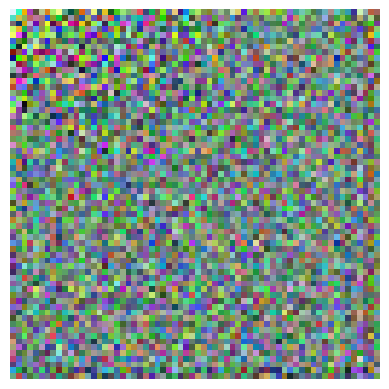

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


unnormalize = transforms.Normalize(mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], std=[1 / 0.5, 1 / 0.5, 1 / 0.5])
fake_image = unnormalize(fake_image.squeeze(0))  
fake_image = fake_image.permute(1, 2, 0).cpu().numpy()  


plt.imshow(fake_image.clip(0, 1))  
plt.axis("off")
plt.show()

In [ ]:
batch_size = 8
noise = torch.randn(batch_size, noise_dim).to(device) 
class_ids = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7]).to(device) 
class_embeddings = class_embedding_layer(class_ids) 


with torch.no_grad():
    fake_images = generator(noise, class_embeddings)  

## Generator with images

In [ ]:
class GeneratorWithImage(nn.Module):
    def __init__(self, noise_dim=100, class_dim=40, image_channels=3):
        super(GeneratorWithImage, self).__init__()

       
        self.image_encoder = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()  
        )

      
        self.fc = nn.Linear(noise_dim + class_dim + 128 * 8 * 8, 4 * 4 * 1024) 

        
        self.resblock1 = ResBlockUp(1024, 512)
        self.resblock2 = ResBlockUp(512, 256)
        self.resblock3 = ResBlockUp(256, 128)
        self.resblock4 = ResBlockUp(128, 64)

       
        self.conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.tanh = nn.Tanh() 

    def forward(self, noise, class_embedding, input_image):
      
        image_features = self.image_encoder(input_image) 

       
        x = torch.cat([noise, class_embedding, image_features], dim=1)  
       
        x = self.fc(x).view(-1, 1024, 4, 4) 

        
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)

       
        x = self.conv(x)
        return self.tanh(x)

In [ ]:

def train_gan(generator, discriminator, data_loader, class_embedding_layer, num_epochs=20, noise_dim=100, lr=0.0002):
    
    optimizer_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=lr * 0.5, betas=(0.5, 0.999))  

    
    gan_loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(data_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            
            optimizer_disc.zero_grad()
            batch_size = images.size(0)

            
            noise = torch.randn(batch_size, noise_dim).to(device)
            class_embeddings = class_embedding_layer(labels).detach()
            input_images = batch["image"].to(device)  
            fake_images = generator(noise, class_embedding, input_images)
           

            
            real_images_noisy = images + 0.05 * torch.randn_like(images).to(device)
            fake_images_noisy = fake_images.detach() + 0.05 * torch.randn_like(fake_images).to(device)

            
            real_labels = torch.full((batch_size, 1), 0.9, device=device)
            fake_labels = torch.full((batch_size, 1), 0.1, device=device)

           
            real_loss = gan_loss_fn(discriminator(real_images_noisy, class_embeddings), real_labels)
            fake_loss = gan_loss_fn(discriminator(fake_images_noisy, class_embeddings), fake_labels)
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            optimizer_disc.step()

            
            optimizer_gen.zero_grad()

            
            noise = torch.randn(batch_size, noise_dim).to(device)
            class_embeddings = class_embedding_layer(labels)
            fake_images = generator(noise, class_embeddings)

            
            gen_loss = gan_loss_fn(discriminator(fake_images, class_embeddings), real_labels)
            gen_loss.backward()
            optimizer_gen.step()


        print(f"Epoch [{epoch + 1}/{num_epochs}] | Gen Loss: {gen_loss.item():.4f} | Disc Loss: {disc_loss.item():.4f}")

In [ ]:
train_gan(GeneratorWithImage, discriminator, data_loader, class_embedding_layer, num_epochs=20, noise_dim=noise_dim, lr=lr)

TypeError: Module.parameters() missing 1 required positional argument: 'self'

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize to [-1, 1]
])


image_dataset = ImageDataset(image_folder=image_dir, labels_csv=labels_csv, transform=image_transforms)
data_loader = DataLoader(image_dataset, batch_size=16, shuffle=True)


noise_dim = 100
class_dim = 40 
lr = 0.0002
num_epochs = 20


generator = Generator(noise_dim=noise_dim, class_dim=class_dim).to(device)
discriminator = Discriminator(class_dim=class_dim).to(device)


class_embedding_layer = nn.Embedding(num_embeddings=40, embedding_dim=40).to(device)

## Using image feature vector as input to generator

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##### For training the resnet18

In [ ]:

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)  
        self.image_dir = image_dir  
        self.transform = transform 

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        filename = self.labels_df.iloc[idx]['filename']
        label = int(self.labels_df.iloc[idx]['label'])  

        subfolder = filename.split('_')[0] 
        image_path = os.path.join(self.image_dir, subfolder, filename)

        image = Image.open(image_path).convert("RGB")  

        if self.transform:
            image = self.transform(image)

        return image, label


def train_model(model, train_loader, val_loader, device, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=(running_loss / (total / train_loader.batch_size)),
                             acc=(correct / total))

        scheduler.step()
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(train_loader):.4f}, "
              f"Accuracy: {correct / total:.4f}")

    print("Training complete!")


image_dir = "EpochHunters/Subset_128x128/Subset_128x128"
csv_file = "EpochHunters/labels.csv"
batch_size = 32
num_epochs = 60
learning_rate = 0.001
num_classes = 40


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_dataset = CustomImageDataset(csv_file=csv_file, image_dir=image_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)


for param in resnet.parameters():
    param.requires_grad = False


resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes) 
)
resnet = resnet.to(device)


train_model(resnet, train_loader, val_loader, device, num_epochs=num_epochs, lr=learning_rate)


model_path = "EpochHunters/resnet18_transfer_learning.pth"
torch.save(resnet.state_dict(), model_path)
print(f"Model saved to {model_path}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch [1/60]: 100%|██████████| 50/50 [08:26<00:00, 10.13s/it, acc=0.328, loss=2.8]


Epoch [1/60] - Loss: 2.7924, Accuracy: 0.3277


Epoch [2/60]: 100%|██████████| 50/50 [00:08<00:00,  6.21it/s, acc=0.702, loss=1.25]


Epoch [2/60] - Loss: 1.2429, Accuracy: 0.7018


Epoch [3/60]: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s, acc=0.772, loss=0.876]


Epoch [3/60] - Loss: 0.8734, Accuracy: 0.7719


Epoch [4/60]: 100%|██████████| 50/50 [00:08<00:00,  6.17it/s, acc=0.836, loss=0.659]


Epoch [4/60] - Loss: 0.6570, Accuracy: 0.8365


Epoch [5/60]: 100%|██████████| 50/50 [00:06<00:00,  7.32it/s, acc=0.844, loss=0.571]


Epoch [5/60] - Loss: 0.5700, Accuracy: 0.8440


Epoch [6/60]: 100%|██████████| 50/50 [00:08<00:00,  6.10it/s, acc=0.885, loss=0.449]


Epoch [6/60] - Loss: 0.4483, Accuracy: 0.8853


Epoch [7/60]: 100%|██████████| 50/50 [00:07<00:00,  7.04it/s, acc=0.889, loss=0.4]


Epoch [7/60] - Loss: 0.3992, Accuracy: 0.8891


Epoch [8/60]: 100%|██████████| 50/50 [00:08<00:00,  6.07it/s, acc=0.888, loss=0.41]


Epoch [8/60] - Loss: 0.4089, Accuracy: 0.8878


Epoch [9/60]: 100%|██████████| 50/50 [00:06<00:00,  7.25it/s, acc=0.898, loss=0.385]


Epoch [9/60] - Loss: 0.3836, Accuracy: 0.8979


Epoch [10/60]: 100%|██████████| 50/50 [00:08<00:00,  6.20it/s, acc=0.907, loss=0.369]


Epoch [10/60] - Loss: 0.3678, Accuracy: 0.9066


Epoch [11/60]: 100%|██████████| 50/50 [00:06<00:00,  7.31it/s, acc=0.909, loss=0.369]


Epoch [11/60] - Loss: 0.3682, Accuracy: 0.9085


Epoch [12/60]: 100%|██████████| 50/50 [00:08<00:00,  6.17it/s, acc=0.909, loss=0.36]


Epoch [12/60] - Loss: 0.3594, Accuracy: 0.9085


Epoch [13/60]: 100%|██████████| 50/50 [00:06<00:00,  7.37it/s, acc=0.925, loss=0.34]


Epoch [13/60] - Loss: 0.3394, Accuracy: 0.9254


Epoch [14/60]: 100%|██████████| 50/50 [00:07<00:00,  6.26it/s, acc=0.913, loss=0.35]


Epoch [14/60] - Loss: 0.3489, Accuracy: 0.9129


Epoch [15/60]: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s, acc=0.905, loss=0.374]


Epoch [15/60] - Loss: 0.3729, Accuracy: 0.9048


Epoch [16/60]: 100%|██████████| 50/50 [00:07<00:00,  6.46it/s, acc=0.906, loss=0.342]


Epoch [16/60] - Loss: 0.3409, Accuracy: 0.9060


Epoch [17/60]: 100%|██████████| 50/50 [00:07<00:00,  7.13it/s, acc=0.919, loss=0.347]


Epoch [17/60] - Loss: 0.3465, Accuracy: 0.9192


Epoch [18/60]: 100%|██████████| 50/50 [00:07<00:00,  6.47it/s, acc=0.916, loss=0.357]


Epoch [18/60] - Loss: 0.3557, Accuracy: 0.9160


Epoch [19/60]: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s, acc=0.91, loss=0.362]


Epoch [19/60] - Loss: 0.3611, Accuracy: 0.9104


Epoch [20/60]: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, acc=0.917, loss=0.342]


Epoch [20/60] - Loss: 0.3407, Accuracy: 0.9167


Epoch [21/60]: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s, acc=0.917, loss=0.346]


Epoch [21/60] - Loss: 0.3450, Accuracy: 0.9173


Epoch [22/60]: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s, acc=0.912, loss=0.335]


Epoch [22/60] - Loss: 0.3338, Accuracy: 0.9117


Epoch [23/60]: 100%|██████████| 50/50 [00:07<00:00,  6.26it/s, acc=0.906, loss=0.372]


Epoch [23/60] - Loss: 0.3707, Accuracy: 0.9060


Epoch [24/60]: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, acc=0.912, loss=0.362]


Epoch [24/60] - Loss: 0.3611, Accuracy: 0.9123


Epoch [25/60]: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s, acc=0.908, loss=0.341]


Epoch [25/60] - Loss: 0.3398, Accuracy: 0.9079


Epoch [26/60]: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, acc=0.915, loss=0.351]


Epoch [26/60] - Loss: 0.3504, Accuracy: 0.9148


Epoch [27/60]: 100%|██████████| 50/50 [00:08<00:00,  6.00it/s, acc=0.917, loss=0.343]


Epoch [27/60] - Loss: 0.3421, Accuracy: 0.9167


Epoch [28/60]: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, acc=0.92, loss=0.337]


Epoch [28/60] - Loss: 0.3363, Accuracy: 0.9204


Epoch [29/60]: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s, acc=0.912, loss=0.35]


Epoch [29/60] - Loss: 0.3487, Accuracy: 0.9117


Epoch [30/60]: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, acc=0.914, loss=0.35]


Epoch [30/60] - Loss: 0.3495, Accuracy: 0.9135


Epoch [31/60]: 100%|██████████| 50/50 [00:08<00:00,  6.14it/s, acc=0.905, loss=0.359]


Epoch [31/60] - Loss: 0.3584, Accuracy: 0.9048


Epoch [32/60]: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s, acc=0.915, loss=0.345]


Epoch [32/60] - Loss: 0.3444, Accuracy: 0.9148


Epoch [33/60]: 100%|██████████| 50/50 [00:07<00:00,  6.42it/s, acc=0.909, loss=0.35]


Epoch [33/60] - Loss: 0.3492, Accuracy: 0.9085


Epoch [34/60]: 100%|██████████| 50/50 [00:08<00:00,  6.13it/s, acc=0.912, loss=0.336]


Epoch [34/60] - Loss: 0.3351, Accuracy: 0.9117


Epoch [35/60]: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s, acc=0.913, loss=0.353]


Epoch [35/60] - Loss: 0.3518, Accuracy: 0.9129


Epoch [36/60]: 100%|██████████| 50/50 [00:08<00:00,  6.02it/s, acc=0.908, loss=0.356]


Epoch [36/60] - Loss: 0.3554, Accuracy: 0.9079


Epoch [37/60]: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, acc=0.919, loss=0.328]


Epoch [37/60] - Loss: 0.3276, Accuracy: 0.9192


Epoch [38/60]: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s, acc=0.905, loss=0.36]


Epoch [38/60] - Loss: 0.3592, Accuracy: 0.9048


Epoch [39/60]: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, acc=0.921, loss=0.314]


Epoch [39/60] - Loss: 0.3133, Accuracy: 0.9211


Epoch [40/60]: 100%|██████████| 50/50 [00:08<00:00,  6.11it/s, acc=0.9, loss=0.352]


Epoch [40/60] - Loss: 0.3513, Accuracy: 0.9004


Epoch [41/60]: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s, acc=0.914, loss=0.351]


Epoch [41/60] - Loss: 0.3498, Accuracy: 0.9135


Epoch [42/60]: 100%|██████████| 50/50 [00:08<00:00,  6.23it/s, acc=0.914, loss=0.36]


Epoch [42/60] - Loss: 0.3593, Accuracy: 0.9142


Epoch [43/60]: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, acc=0.902, loss=0.366]


Epoch [43/60] - Loss: 0.3656, Accuracy: 0.9023


Epoch [44/60]: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s, acc=0.91, loss=0.357]


Epoch [44/60] - Loss: 0.3559, Accuracy: 0.9104


Epoch [45/60]: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s, acc=0.926, loss=0.342]


Epoch [45/60] - Loss: 0.3409, Accuracy: 0.9261


Epoch [46/60]: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s, acc=0.904, loss=0.357]


Epoch [46/60] - Loss: 0.3563, Accuracy: 0.9035


Epoch [47/60]: 100%|██████████| 50/50 [00:07<00:00,  6.30it/s, acc=0.916, loss=0.341]


Epoch [47/60] - Loss: 0.3403, Accuracy: 0.9160


Epoch [48/60]: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s, acc=0.912, loss=0.346]


Epoch [48/60] - Loss: 0.3451, Accuracy: 0.9123


Epoch [49/60]: 100%|██████████| 50/50 [00:08<00:00,  6.15it/s, acc=0.912, loss=0.357]


Epoch [49/60] - Loss: 0.3561, Accuracy: 0.9117


Epoch [50/60]: 100%|██████████| 50/50 [00:06<00:00,  7.30it/s, acc=0.904, loss=0.377]


Epoch [50/60] - Loss: 0.3764, Accuracy: 0.9035


Epoch [51/60]: 100%|██████████| 50/50 [00:07<00:00,  6.31it/s, acc=0.914, loss=0.339]


Epoch [51/60] - Loss: 0.3384, Accuracy: 0.9142


Epoch [52/60]: 100%|██████████| 50/50 [00:06<00:00,  7.39it/s, acc=0.914, loss=0.349]


Epoch [52/60] - Loss: 0.3483, Accuracy: 0.9142


Epoch [53/60]: 100%|██████████| 50/50 [00:08<00:00,  6.13it/s, acc=0.909, loss=0.351]


Epoch [53/60] - Loss: 0.3502, Accuracy: 0.9085


Epoch [54/60]: 100%|██████████| 50/50 [00:06<00:00,  7.42it/s, acc=0.913, loss=0.336]


Epoch [54/60] - Loss: 0.3355, Accuracy: 0.9129


Epoch [55/60]: 100%|██████████| 50/50 [00:08<00:00,  6.22it/s, acc=0.909, loss=0.357]


Epoch [55/60] - Loss: 0.3556, Accuracy: 0.9091


Epoch [56/60]: 100%|██████████| 50/50 [00:06<00:00,  7.38it/s, acc=0.907, loss=0.353]


Epoch [56/60] - Loss: 0.3516, Accuracy: 0.9073


Epoch [57/60]: 100%|██████████| 50/50 [00:07<00:00,  6.25it/s, acc=0.907, loss=0.345]


Epoch [57/60] - Loss: 0.3441, Accuracy: 0.9073


Epoch [58/60]: 100%|██████████| 50/50 [00:06<00:00,  7.45it/s, acc=0.91, loss=0.36]


Epoch [58/60] - Loss: 0.3595, Accuracy: 0.9104


Epoch [59/60]: 100%|██████████| 50/50 [00:07<00:00,  6.28it/s, acc=0.909, loss=0.353]


Epoch [59/60] - Loss: 0.3525, Accuracy: 0.9091


Epoch [60/60]: 100%|██████████| 50/50 [00:06<00:00,  7.45it/s, acc=0.915, loss=0.34]


Epoch [60/60] - Loss: 0.3388, Accuracy: 0.9148
Training complete!
Model saved to /content/drive/MyDrive/resnet18_transfer_learning.pth


AttributeError: 'Sequential' object has no attribute 'in_features'

In [ ]:
resnet_loaded = models.resnet18(pretrained=True)

in_features = resnet_loaded.fc.in_features
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


resnet_loaded.fc = nn.Sequential(
    nn.Linear(in_features, 512),  
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 40)  
)
model_path = "EpochHunters/resnet18_transfer_learning.pth"

resnet_loaded.load_state_dict(torch.load(model_path))
resnet_loaded = resnet_loaded.to(device)
resnet_loaded.eval()
print("Model loaded successfully!")



def extract_features(model, image_path, device, transform):
    model.eval()  
    with torch.no_grad():
       
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  

        
        features = model.fc[0](model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.conv1(image)))))).view(1, -1))
        return features


sample_image_path = "EpochHunters/Subset_128x128/Subset_128x128/n02106662/n02106662_10232.JPEG"
features = extract_features(resnet_loaded, sample_image_path, device, transform)
print(f"Extracted Features Shape: {features.shape}")


Model loaded successfully!
Extracted Features Shape: torch.Size([1, 512])


C:\Users\CSE IIT BHILAI\AppData\Local\Temp\ipykernel_14952\1467027424.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_loaded.load_state_dict(torch.load(model_pat

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import random


class ImageFeatureDataset(Dataset):
    def __init__(self, image_dir, transform, resnet_model, device):
        self.image_dir = image_dir
        self.transform = transform
        self.resnet_model = resnet_model
        self.device = device
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {} 

        
        class_idx = 0
        for subfolder in os.listdir(image_dir):
            subfolder_path = os.path.join(image_dir, subfolder)
            if os.path.isdir(subfolder_path):
                self.class_to_idx[subfolder] = class_idx
                for img_name in os.listdir(subfolder_path):
                    if img_name.endswith('.JPEG'):
                        self.image_paths.append(os.path.join(subfolder_path, img_name))
                        self.labels.append(subfolder)  # Store the class name (subfolder name)
                class_idx += 1

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.class_to_idx[self.labels[idx]]  
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)

        
        with torch.no_grad():
            feature = self.resnet_model(image).squeeze(0)

        return feature, label, img_path



resnet = models.resnet18(pretrained=True)
in_features = resnet.fc.in_features
resnet.fc = nn.Identity()  
resnet = resnet.to(device)


transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


image_dir = "EpochHunters/Subset_128x128"
dataset = ImageFeatureDataset(image_dir=image_dir, transform=transform, resnet_model=resnet, device=device)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


class Generator(nn.Module):
    def __init__(self, z_dim, feature_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim + feature_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 128*128*3)  
        self.tanh = nn.Tanh()

    def forward(self, z, features):
        x = torch.cat((z, features), dim=1)  
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.tanh(x).view(-1, 3, 128, 128) 
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.fc1 = nn.Linear(256 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)


z_dim = 100  
feature_dim = 512 
generator = Generator(z_dim, feature_dim).to(device)
discriminator = Discriminator().to(device)


criterion = nn.BCELoss()
lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


num_epochs = 100
for epoch in range(num_epochs):
    for i, (features, labels, paths) in enumerate(dataloader):
        batch_size = features.size(0) 
        z = torch.randn(batch_size, z_dim).to(device) 
        features = features.view(batch_size, -1)  

        
        fake_images = generator(z, features) 

       
        real_labels = torch.ones(batch_size, 1).to(device)  
        fake_labels = torch.zeros(batch_size, 1).to(device) 

        
        optimizer_D.zero_grad()

       
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        
        outputs = discriminator(fake_images.detach()) 
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()

        optimizer_D.step()

       
        optimizer_G.zero_grad()

        outputs = discriminator(fake_images)  
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()

        optimizer_G.step()

    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}")




ValueError: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.